In [1]:
# our standard imports 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as miss


# Preprocessing tools
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

# Models and evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
# setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## matplotlib style


fav_style = ('ggplot','tableau-colorblind10')
fav_context = {'context':'notebook', 'font_scale':1.1}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'

# Set global scikit_learn configuration
from sklearn import set_config
set_config(display='diagram')

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.2}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'

In [3]:
def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True): 
    """Evaluates a scikit learn regression model using r-squared and RMSE
    FOR SLIDES VERS DOES MULTIPLE PRINT STATEMENTS FOR VERTICAL DISPLAY OF INFO"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    

    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
    
    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))
        
    else: 
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")

def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
    coeffs.loc['intercept'] = lin_reg.intercept_
    return coeffs

def plot_coefficients(coeffs, sort_values=True, top_n=None, figsize=(6,4),
                     title="Linear Regression Coefficients", xlabel='Coefficient'):
    """Plots a Series of coefficients as horizotal bar chart, with option to sort
    and to only keep top_n coefficients"""
        
    if top_n is not None:
        top_n = coeffs.abs().rank().sort_values(ascending=False).head(top_n)
        coeffs = coeffs.loc[top_n.index]
        
    if sort_values:
        coeffs = coeffs.sort_values()

        
        
    ax = coeffs.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax


def get_importances(rf_reg):
    importances = pd.Series(rf_reg.feature_importances_, index= rf_reg.feature_names_in_)
    return importances


def plot_importances(importances, sort_values=True, top_n=None, figsize=(6,4),
                     title="Feature Importance", xlabel='Importance'):
    if sort_values:
        importances = importances.sort_values()
        
    if top_n is not None:
        importances = importances.tail(top_n)
        
        
    ax = importances.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax

In [4]:
## Load the joblib file stored in the models folder
fname = "Best models.joblib"
loaded = joblib.load(fname)
# Preview the contents of the loaded joblib objects
loaded.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'LinearRegression', 'RandomForestRegressor'])

In [5]:
X_train = loaded['X_train']
X_test = loaded['X_test']
y_train = loaded['y_train']
y_test = loaded['y_test']

preprocessor = loaded['preprocessor']
lin_reg = loaded['LinearRegression']
rf_reg = loaded['RandomForestRegressor']

In [6]:
X_train.head()

Item_Weight Item_Fat_Content  Item_Visibility              Item_Type  \
8269        7.220          Regular         0.064142           Baking Goods   
7604        6.135          Low Fat         0.079294            Soft Drinks   
2762       12.150          Low Fat         0.028593              Household   
6464        5.945          Low Fat         0.093009              Household   
4707       18.200          Regular         0.066285  Fruits and Vegetables   

      Item_MRP Outlet_Identifier  Outlet_Establishment_Year Outlet_Size  \
8269   61.2510            OUT010                       1998     Unknown   
7604  111.2860            OUT018                       2009      Medium   
2762  151.0708            OUT035                       2004       Small   
6464  127.8652            OUT035                       2004       Small   
4707  247.2092            OUT035                       2004       Small   

     Outlet_Location_Type        Outlet_Type  
8269               Tier 3      Grocery Store  
7604               Tier 3  Supermarket Type2  
2762               Tier 2  Supermarket Type1  
6464               Tier 2  Supermarket Type1  
4707               Tier 2  Supermarket Type1

In [7]:
feature_names = preprocessor.get_feature_names_out()

## Use the preprocessor to transform X_train into X_train_df
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          index=X_train.index,
                          columns=feature_names)


## Use the preprocessor to transform X_test into X_test_df 

X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                         index=X_test.index,
                          columns=feature_names)
X_train_df.head()

Item_Weight  Item_Visibility  Item_MRP  Outlet_Establishment_Year  \
8269        7.220         0.064142   61.2510                     1998.0   
7604        6.135         0.079294  111.2860                     2009.0   
2762       12.150         0.028593  151.0708                     2004.0   
6464        5.945         0.093009  127.8652                     2004.0   
4707       18.200         0.066285  247.2092                     2004.0   

      Item_Fat_Content_Regular  Item_Type_Baking Goods  Item_Type_Breads  \
8269                       1.0                     1.0               0.0   
7604                       0.0                     0.0               0.0   
2762                       0.0                     0.0               0.0   
6464                       0.0                     0.0               0.0   
4707                       1.0                     0.0               0.0   

      Item_Type_Breakfast  Item_Type_Canned  Item_Type_Dairy  ...  \
8269                  0.0               0.0              0.0  ...   
7604                  0.0               0.0              0.0  ...   
2762                  0.0               0.0              0.0  ...   
6464                  0.0               0.0              0.0  ...   
4707                  0.0               0.0              0.0  ...   

      Outlet_Size_Medium  Outlet_Size_Small  Outlet_Size_Unknown  \
8269                 0.0                0.0                  1.0   
7604                 1.0                0.0                  0.0   
2762                 0.0                1.0                  0.0   
6464                 0.0                1.0                  0.0   
4707                 0.0                1.0                  0.0   

      Outlet_Location_Type_Tier 1  Outlet_Location_Type_Tier 2  \
8269                          0.0                          0.0   
7604                          0.0                          0.0   
2762                          0.0                          1.0   
6464                          0.0                          1.0   
4707                          0.0                          1.0   

      Outlet_Location_Type_Tier 3  Outlet_Type_Grocery Store  \
8269                          1.0                        1.0   
7604                          1.0                        0.0   
2762                          0.0                        0.0   
6464                          0.0                        0.0   
4707                          0.0                        0.0   

      Outlet_Type_Supermarket Type1  Outlet_Type_Supermarket Type2  \
8269                            0.0                            0.0   
7604                            0.0                            1.0   
2762                            1.0                            0.0   
6464                            1.0                            0.0   
4707                            1.0                            0.0   

      Outlet_Type_Supermarket Type3  
8269                            0.0  
7604                            0.0  
2762                            0.0  
6464                            0.0  
4707                            0.0  

[5 rows x 42 columns]

In [9]:
## using my evaluation function to see the metrics
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df, y_test)

In [11]:
pd.set_option('display.float_format',lambda x: f"{x:,.2f}")

coeffs = get_coefficients(lin_reg)
coeffs

Item_Weight                          1.42
Item_Visibility                   -276.34
Item_MRP                            15.60
Outlet_Establishment_Year           -0.14
Item_Fat_Content_Regular            31.53
Item_Type_Baking Goods               9.26
Item_Type_Breads                    -3.13
Item_Type_Breakfast                 69.92
Item_Type_Canned                    22.78
Item_Type_Dairy                    -48.91
Item_Type_Frozen Foods              -5.22
Item_Type_Fruits and Vegetables     15.95
Item_Type_Hard Drinks               50.06
Item_Type_Health and Hygiene       -41.46
Item_Type_Household                -68.97
Item_Type_Meat                     -15.81
Item_Type_Others                    17.14
Item_Type_Seafood                   99.00
Item_Type_Snack Foods              -11.68
Item_Type_Soft Drinks             -117.34
Item_Type_Starchy Foods             30.54
Outlet_Identifier_OUT010          -461.76
Outlet_Identifier_OUT013            -0.97
Outlet_Identifier_OUT017          

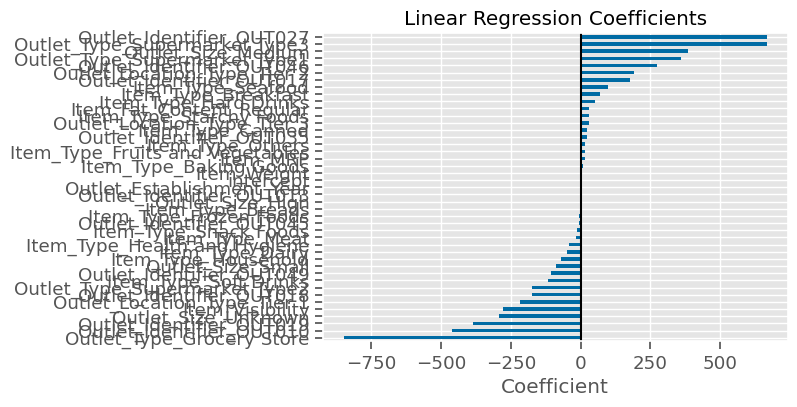

<AxesSubplot: title={'center': 'Linear Regression Coefficients'}, xlabel='Coefficient'>

In [12]:
## plotting the coefficients
plot_coefficients(coeffs)

## Evaulating the Random Forest

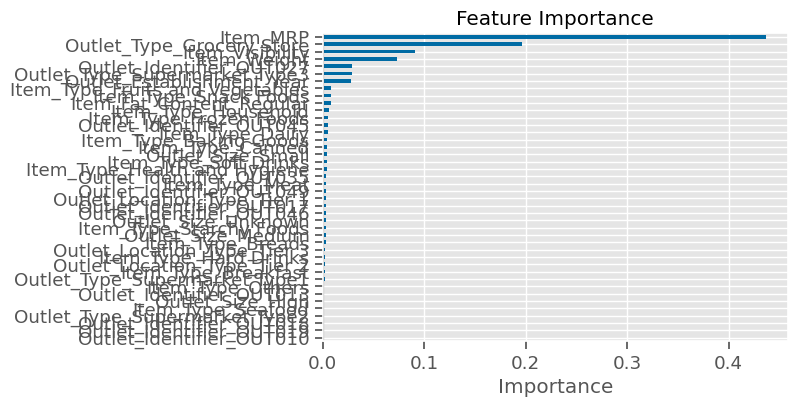

<AxesSubplot: title={'center': 'Feature Importance'}, xlabel='Importance'>

In [13]:
# measuring the random forest metrics
evaluate_regression(rf_reg,X_train_df,y_train, X_test_df, y_test)

## extract the plot the feature importances
importances = get_importances(rf_reg)
plot_importances(importances)

## Permutation Importance for random forest

In [14]:
from sklearn.inspection import permutation_importance
## running the performatation importance on the random forest
result = permutation_importance(rf_reg, X_test_df, y_test,scoring='r2',
                                n_jobs=-1,random_state=SEED)
result.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

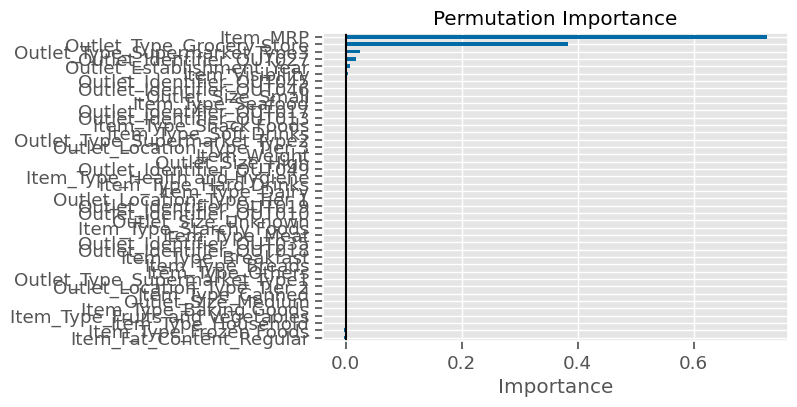

<AxesSubplot: title={'center': 'Permutation Importance'}, xlabel='Importance'>

In [15]:
## saving the average importances as a Series
perm_importances = pd.Series(result['importances_mean'], index=rf_reg.feature_names_in_)

plot_importances(perm_importances,title='Permutation Importance')

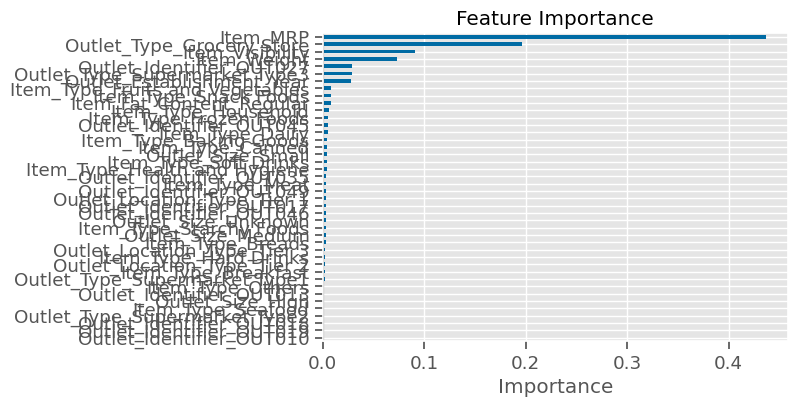

<AxesSubplot: title={'center': 'Feature Importance'}, xlabel='Importance'>

In [16]:
# Comparing to the random forst feature importance
plot_importances(importances)

## LinearRegression Permutation Importance

In [18]:
## running the performatation importance on the random forest
results_linreg = permutation_importance(lin_reg, X_test_df, y_test,scoring='r2', n_repeats=3,
                                n_jobs=-1,random_state=SEED)
result.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

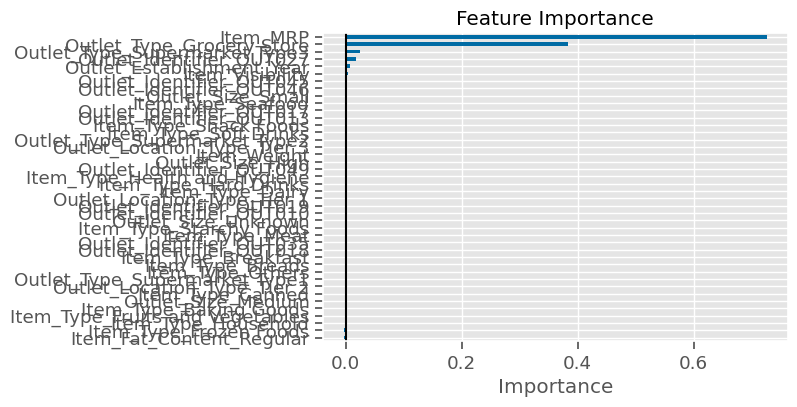

<AxesSubplot: title={'center': 'Feature Importance'}, xlabel='Importance'>

In [19]:
perm_importances_linreg = pd.Series(result['importances_mean'], 
                                    index=lin_reg.feature_names_in_)

plot_importances(perm_importances_linreg)

In [20]:
final_plot_df = pd.concat([X_train_df, y_train], axis=1)
corr = final_plot_df.corr()
corr

Item_Weight  Item_Visibility  Item_MRP  \
Item_Weight                             1.00            -0.01      0.03   
Item_Visibility                        -0.01             1.00      0.01   
Item_MRP                                0.03             0.01      1.00   
Outlet_Establishment_Year              -0.02            -0.07      0.02   
Item_Fat_Content_Regular               -0.03             0.04     -0.00   
Item_Type_Baking Goods                 -0.03             0.02     -0.07   
Item_Type_Breads                       -0.06             0.00      0.01   
Item_Type_Breakfast                     0.00             0.05      0.00   
Item_Type_Canned                       -0.03             0.01     -0.02   
Item_Type_Dairy                         0.03             0.03      0.03   
Item_Type_Frozen Foods                 -0.01            -0.01     -0.02   
Item_Type_Fruits and Vegetables         0.04             0.01      0.02   
Item_Type_Hard Drinks                  -0.05             0.01     -0.01   
Item_Type_Health and Hygiene            0.01            -0.05     -0.04   
Item_Type_Household                     0.05            -0.03      0.05   
Item_Type_Meat                         -0.00            -0.02     -0.01   
Item_Type_Others                        0.03            -0.02     -0.01   
Item_Type_Seafood                      -0.01             0.02      0.01   
Item_Type_Snack Foods                   0.01             0.01      0.03   
Item_Type_Soft Drinks                  -0.05             0.00     -0.03   
Item_Type_Starchy Foods                 0.02            -0.00      0.03   
Outlet_Identifier_OUT010                0.00             0.18      0.01   
Outlet_Identifier_OUT013                0.01            -0.06     -0.01   
Outlet_Identifier_OUT017               -0.00            -0.03     -0.01   
Outlet_Identifier_OUT018               -0.01            -0.03      0.00   
Outlet_Identifier_OUT019                0.01             0.21     -0.01   
Outlet_Identifier_OUT027                0.01            -0.05     -0.02   
Outlet_Identifier_OUT035                0.00            -0.03      0.03   
Outlet_Identifier_OUT045               -0.02            -0.04      0.00   
Outlet_Identifier_OUT046               -0.00            -0.04      0.01   
Outlet_Identifier_OUT049                0.00            -0.04     -0.00   
Outlet_Size_High                        0.01            -0.06     -0.01   
Outlet_Size_Medium                      0.00            -0.08     -0.01   
Outlet_Size_Small                       0.00             0.07      0.02   
Outlet_Size_Unknown                    -0.01             0.05      0.00   
Outlet_Location_Type_Tier 1             0.01             0.07      0.00   
Outlet_Location_Type_Tier 2            -0.01            -0.07      0.01   
Outlet_Location_Type_Tier 3             0.01             0.00     -0.02   
Outlet_Type_Grocery Store               0.01             0.29      0.00   
Outlet_Type_Supermarket Type1          -0.01            -0.15      0.01   
Outlet_Type_Supermarket Type2          -0.01            -0.03      0.00   
Outlet_Type_Supermarket Type3           0.01            -0.05     -0.02   
Item_Outlet_Sales                       0.02            -0.13      0.57   

                                 Outlet_Establishment_Year  \
Item_Weight                                          -0.02   
Item_Visibility                                      -0.07   
Item_MRP                                              0.02   
Outlet_Establishment_Year                             1.00   
Item_Fat_Content_Regular                              0.01   
Item_Type_Baking Goods                                0.00   
Item_Type_Breads                                     -0.00   
Item_Type_Breakfast                                  -0.01   
Item_Type_Canned                                      0.01   
Item_Type_Dairy                                      -0.02   
Item_Type_Frozen Foods                            

In [21]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2131 entries, 8077 to 737
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                2131 non-null   float64
 1   Item_Fat_Content           2131 non-null   object 
 2   Item_Visibility            2131 non-null   float64
 3   Item_Type                  2131 non-null   object 
 4   Item_MRP                   2131 non-null   float64
 5   Outlet_Identifier          2131 non-null   object 
 6   Outlet_Establishment_Year  2131 non-null   int64  
 7   Outlet_Size                2131 non-null   object 
 8   Outlet_Location_Type       2131 non-null   object 
 9   Outlet_Type                2131 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 183.1+ KB


In [22]:
corr['Item_Outlet_Sales'].sort_values(ascending=False).to_frame().style.bar()


## Global Model Explanations

In [23]:
import shap
shap.initjs()

In [26]:
## taking a sample of the training data
X_shap = shap.sample(X_train_df,nsamples = 500,random_state=42)
y_shap = y_train.loc[X_shap.index]
X_shap.head()

Item_Weight  Item_Visibility  Item_MRP  Outlet_Establishment_Year  \
4951        12.10             0.02    163.75                   1,985.00   
2949        16.00             0.12     58.02                   1,985.00   
220          4.88             0.13     52.93                   1,999.00   
5419        21.10             0.03    143.38                   1,997.00   
2907         8.93             0.01     56.46                   2,007.00   

      Item_Fat_Content_Regular  Item_Type_Baking Goods  Item_Type_Breads  \
4951                      0.00                    0.00              0.00   
2949                      1.00                    0.00              0.00   
220                       1.00                    1.00              0.00   
5419                      0.00                    0.00              0.00   
2907                      0.00                    0.00              0.00   

      Item_Type_Breakfast  Item_Type_Canned  Item_Type_Dairy  ...  \
4951                 0.00              0.00             0.00  ...   
2949                 0.00              0.00             0.00  ...   
220                  0.00              0.00             0.00  ...   
5419                 0.00              0.00             0.00  ...   
2907                 0.00              0.00             0.00  ...   

      Outlet_Size_Medium  Outlet_Size_Small  Outlet_Size_Unknown  \
4951                1.00               0.00                 0.00   
2949                1.00               0.00                 0.00   
220                 1.00               0.00                 0.00   
5419                0.00               1.00                 0.00   
2907                0.00               0.00                 1.00   

      Outlet_Location_Type_Tier 1  Outlet_Location_Type_Tier 2  \
4951                         0.00                         0.00   
2949                         0.00                         0.00   
220                          1.00                         0.00   
5419                         1.00                         0.00   
2907                         0.00                         1.00   

      Outlet_Location_Type_Tier 3  Outlet_Type_Grocery Store  \
4951                         1.00                       0.00   
2949                         1.00                       0.00   
220                          0.00                       0.00   
5419                         0.00                       0.00   
2907                         0.00                       0.00   

      Outlet_Type_Supermarket Type1  Outlet_Type_Supermarket Type2  \
4951                           0.00                           0.00   
2949                           0.00                           0.00   
220                            1.00                           0.00   
5419                           1.00                           0.00   
2907                           1.00                           0.00   

      Outlet_Type_Supermarket Type3  
4951                           1.00  
2949                           1.00  
220                            0.00  
5419                           0.00  
2907                           0.00  

[5 rows x 42 columns]

In [27]:
## instatiating a model explainer with the model
explainer = shap.Explainer(rf_reg)

## Getting shap values from the explainer
shap_values = explainer(X_shap,y_shap)

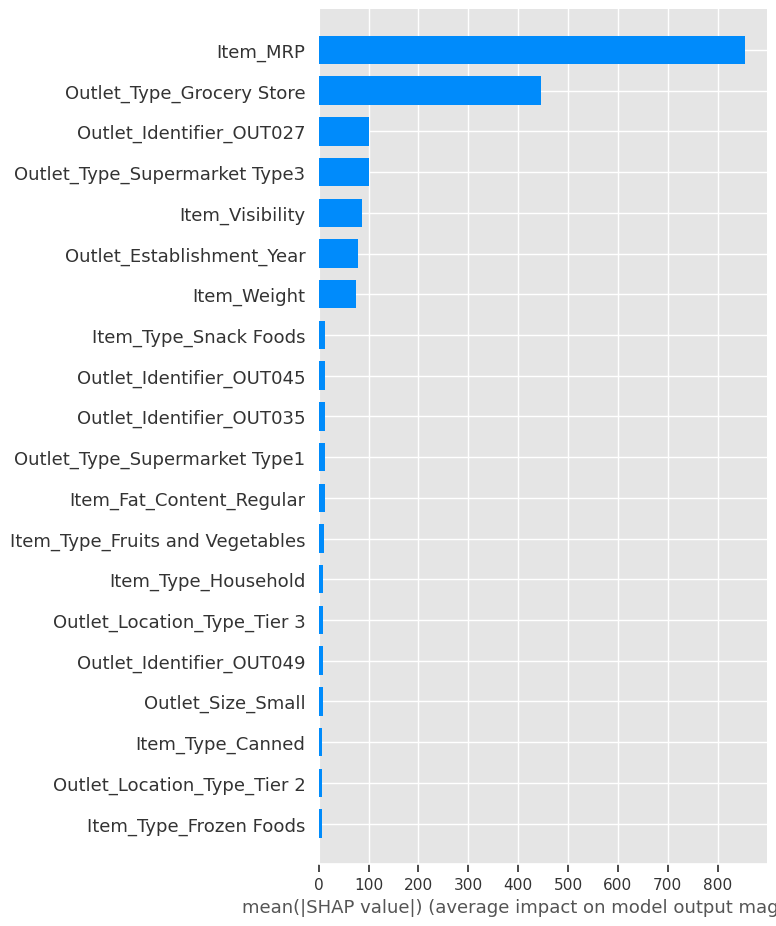

In [28]:
## creating a summary plot
shap.summary_plot(shap_values, features = X_shap, plot_type='bar')

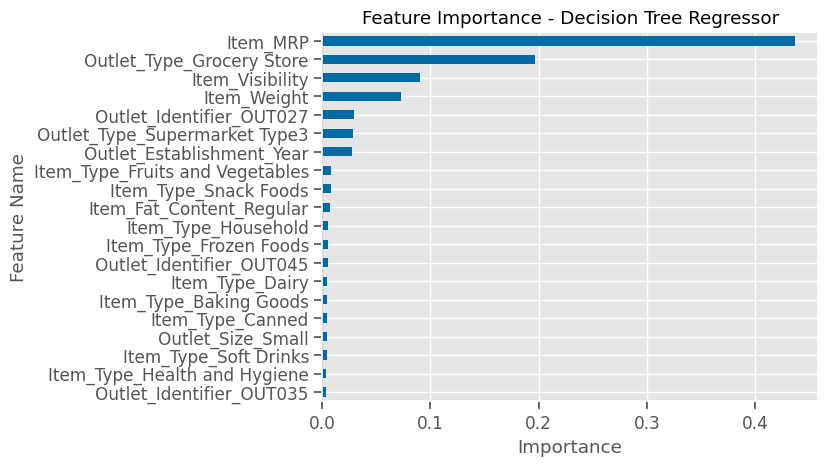

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


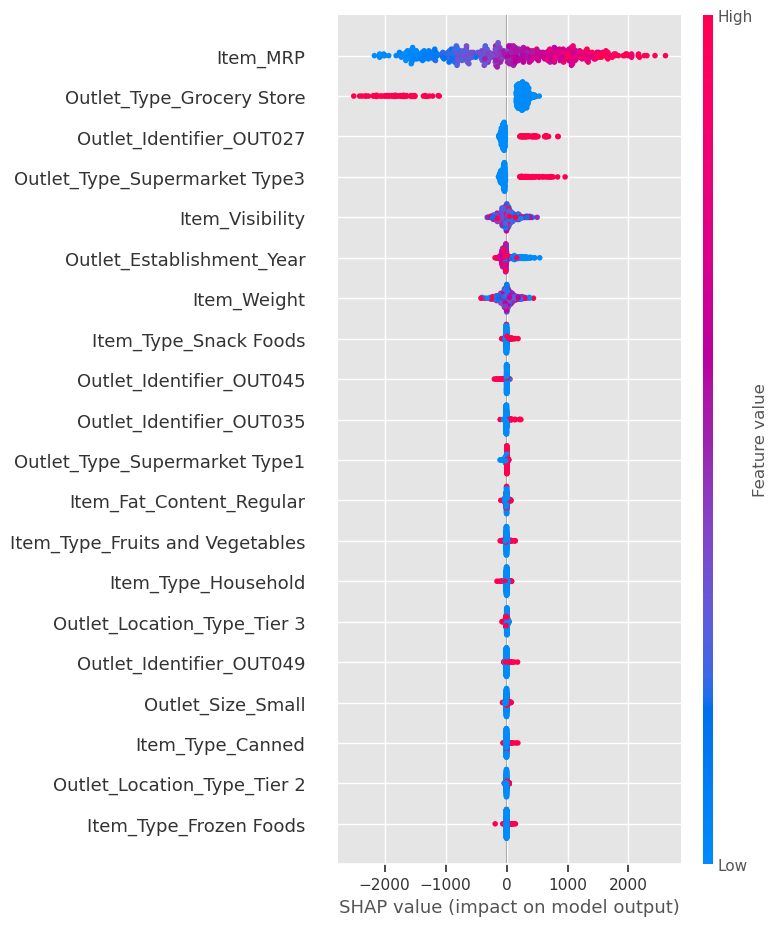

In [29]:
## creating a summary plot with the dot version
shap.summary_plot(shap_values, features = X_shap)

In [26]:
## Creating an explainer for the lin_reg
explainer_linreg = shap.Explainer(lin_reg_final, X_shap)

## get shap values for linreg
shap_values_linreg = explainer_linreg(X_shap)
shap_values_linreg.shape

(500, 42)

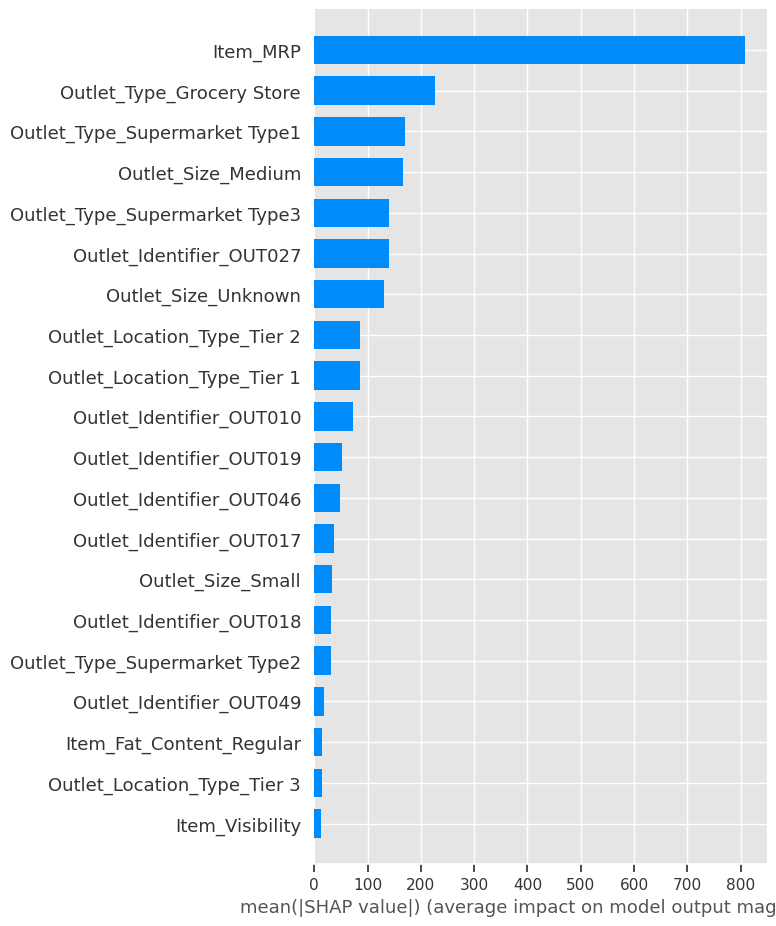

In [27]:
shap.summary_plot(shap_values_linreg, features = X_shap, plot_type='bar')

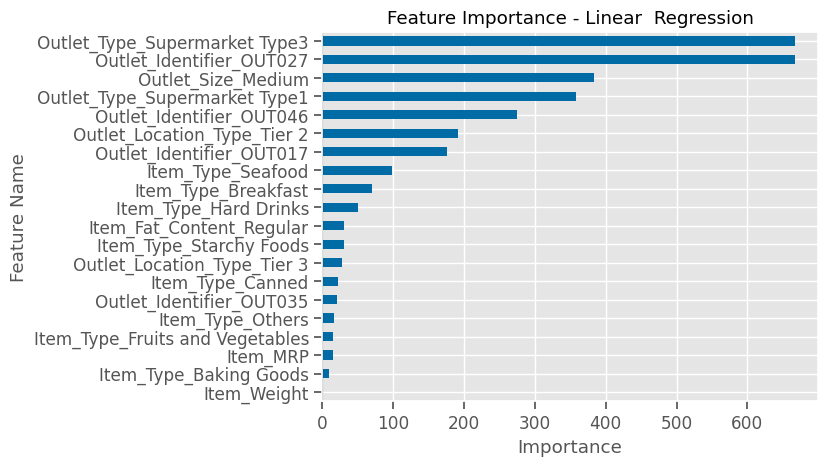

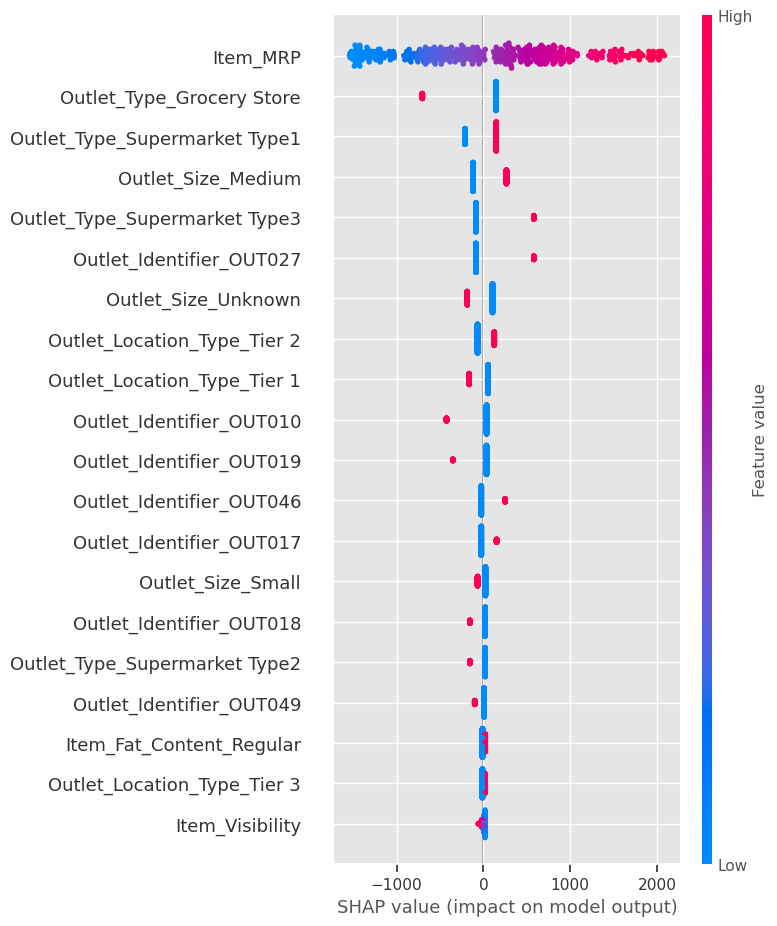

In [28]:
shap.summary_plot(shap_values_linreg, features = X_shap)


## The Top 3 important features based on the ShapBar plot
1. Item MRP 
2. Outlet Type Grocery Store
3. Outlet Type Supermarket type 1

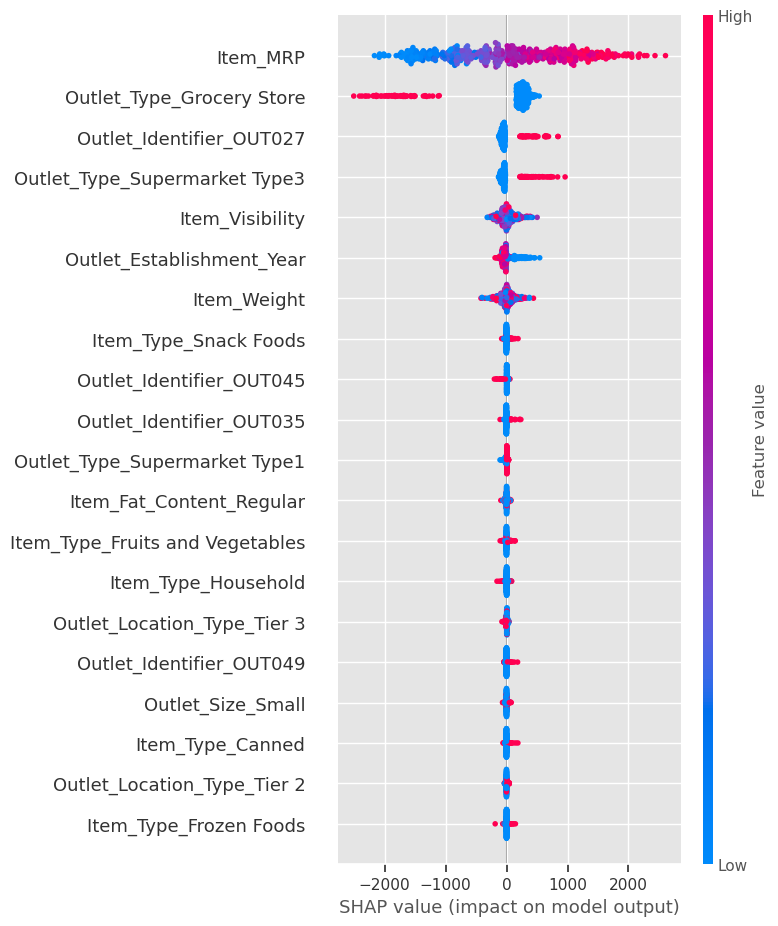

In [30]:
## creating a summary plot
shap.summary_plot(shap_values, features = X_shap, plot_type='dot')

In [29]:
X_shap_local = X_shap.reset_index(drop=True)
y_shap_local = y_shap.reset_index(drop=True)
X_shap_local.head()

Item_Weight  Item_Visibility  Item_MRP  Outlet_Establishment_Year  \
0         7.72             0.07     76.40                   1,987.00   
1         5.11             0.03    163.82                   2,004.00   
2         8.05             0.08    256.46                   2,004.00   
3         8.76             0.05    128.33                   1,999.00   
4         6.59             0.18     82.79                   1,998.00   

   Item_Fat_Content_Regular  Item_Type_Baking Goods  Item_Type_Breads  \
0                      1.00                    0.00              1.00   
1                      0.00                    0.00              0.00   
2                      1.00                    0.00              0.00   
3                      0.00                    0.00              0.00   
4                      0.00                    0.00              0.00   

   Item_Type_Breakfast  Item_Type_Canned  Item_Type_Dairy  ...  \
0                 0.00              0.00             0.00  ...   
1                 0.00              0.00             0.00  ...   
2                 0.00              0.00             0.00  ...   
3                 0.00              0.00             0.00  ...   
4                 0.00              0.00             0.00  ...   

   Outlet_Size_Medium  Outlet_Size_Small  Outlet_Size_Unknown  \
0                0.00               0.00                 0.00   
1                0.00               1.00                 0.00   
2                0.00               1.00                 0.00   
3                1.00               0.00                 0.00   
4                0.00               0.00                 1.00   

   Outlet_Location_Type_Tier 1  Outlet_Location_Type_Tier 2  \
0                         0.00                         0.00   
1                         0.00                         1.00   
2                         0.00                         1.00   
3                         1.00                         0.00   
4                         0.00                         0.00   

   Outlet_Location_Type_Tier 3  Outlet_Type_Grocery Store  \
0                         1.00                       0.00   
1                         0.00                       0.00   
2                         0.00                       0.00   
3                         0.00                       0.00   
4                         1.00                       1.00   

   Outlet_Type_Supermarket Type1  Outlet_Type_Supermarket Type2  \
0                           1.00                           0.00   
1                           1.00                           0.00   
2                           1.00                           0.00   
3                           1.00                           0.00   
4                           0.00                           0.00   

   Outlet_Type_Supermarket Type3  
0                           0.00  
1                           0.00  
2                           0.00  
3                           0.00  
4                           0.00  

[5 rows x 42 columns]

In [30]:
# what is the max/range of infant deaths
X_shap_local['Item_MRP'].describe()

count   500.00
mean    137.08
std      61.60
min      32.36
25%      90.08
50%     140.43
75%     179.52
max     264.72
Name: Item_MRP, dtype: float64

In [31]:
idx_high_MRP = X_shap_local['Item_MRP'].idxmax()
idx_high_MRP

431

In [32]:
X_shap_local.iloc[idx_high_MRP]

Item_Weight                          10.00
Item_Visibility                       0.03
Item_MRP                            264.72
Outlet_Establishment_Year         2,009.00
Item_Fat_Content_Regular              0.00
Item_Type_Baking Goods                0.00
Item_Type_Breads                      0.00
Item_Type_Breakfast                   0.00
Item_Type_Canned                      1.00
Item_Type_Dairy                       0.00
Item_Type_Frozen Foods                0.00
Item_Type_Fruits and Vegetables       0.00
Item_Type_Hard Drinks                 0.00
Item_Type_Health and Hygiene          0.00
Item_Type_Household                   0.00
Item_Type_Meat                        0.00
Item_Type_Others                      0.00
Item_Type_Seafood                     0.00
Item_Type_Snack Foods                 0.00
Item_Type_Soft Drinks                 0.00
Item_Type_Starchy Foods               0.00
Outlet_Identifier_OUT010              0.00
Outlet_Identifier_OUT013              0.00
Outlet_Iden

# Local Explanations

## 2 Rows/outlets I will be choosing based on my insights
1. Item MRP
2. Outlet Type Supermarket type 3

I chose to further my analysis with the Item MRP, because of the high count in feature importance. 
The Outlet Type Supermarket was both high in my tree and linear regression model, which is why I chose this feature. 



In [34]:
X_shap_local = X_shap.reset_index(drop=True)
y_shap_local = y_shap.reset_index(drop=True)
X_shap_local.head()

Item_Weight  Item_Visibility  Item_MRP  Outlet_Establishment_Year  \
0        12.10             0.02    163.75                   1,985.00   
1        16.00             0.12     58.02                   1,985.00   
2         4.88             0.13     52.93                   1,999.00   
3        21.10             0.03    143.38                   1,997.00   
4         8.93             0.01     56.46                   2,007.00   

   Item_Fat_Content_Regular  Item_Type_Baking Goods  Item_Type_Breads  \
0                      0.00                    0.00              0.00   
1                      1.00                    0.00              0.00   
2                      1.00                    1.00              0.00   
3                      0.00                    0.00              0.00   
4                      0.00                    0.00              0.00   

   Item_Type_Breakfast  Item_Type_Canned  Item_Type_Dairy  ...  \
0                 0.00              0.00             0.00  ...   
1                 0.00              0.00             0.00  ...   
2                 0.00              0.00             0.00  ...   
3                 0.00              0.00             0.00  ...   
4                 0.00              0.00             0.00  ...   

   Outlet_Size_Medium  Outlet_Size_Small  Outlet_Size_Unknown  \
0                1.00               0.00                 0.00   
1                1.00               0.00                 0.00   
2                1.00               0.00                 0.00   
3                0.00               1.00                 0.00   
4                0.00               0.00                 1.00   

   Outlet_Location_Type_Tier 1  Outlet_Location_Type_Tier 2  \
0                         0.00                         0.00   
1                         0.00                         0.00   
2                         1.00                         0.00   
3                         1.00                         0.00   
4                         0.00                         1.00   

   Outlet_Location_Type_Tier 3  Outlet_Type_Grocery Store  \
0                         1.00                       0.00   
1                         1.00                       0.00   
2                         0.00                       0.00   
3                         0.00                       0.00   
4                         0.00                       0.00   

   Outlet_Type_Supermarket Type1  Outlet_Type_Supermarket Type2  \
0                           0.00                           0.00   
1                           0.00                           0.00   
2                           1.00                           0.00   
3                           1.00                           0.00   
4                           1.00                           0.00   

   Outlet_Type_Supermarket Type3  
0                           1.00  
1                           1.00  
2                           0.00  
3                           0.00  
4                           0.00  

[5 rows x 42 columns]

### Force Plot - Item max MRP

In [36]:
idx_mrp_max = X_shap_local['Item_MRP'].idxmax()
idx_mrp_max

65

In [37]:
shap.force_plot(explainer.expected_value,
               shap_values=shap_values[idx_mrp_max].values,
               features=X_shap_local.iloc[idx_mrp_max])

#### **Interpretation**
- the higher the Item_MRP the more it pushes the target higher. the grocery outlet type pushes the target lower. 

### Force Plot - Item min MRP


In [38]:
idx_mrp_min = X_shap_local['Item_MRP'].idxmin()
idx_mrp_min

35

In [39]:
shap.force_plot(explainer.expected_value,
               shap_values=shap_values[idx_mrp_min].values,
               features=X_shap_local.iloc[idx_mrp_min])

## Lime - Item Max MRP

In [40]:
from lime.lime_tabular import LimeTabularExplainer
lime_explainer = LimeTabularExplainer(training_data=X_shap_local.values,
                                     feature_names=X_shap_local.columns,
                                     mode='regression')
lime_explainer

In [41]:
exp = lime_explainer.explain_instance(X_shap_local.loc[idx_mrp_max],
                                     rf_reg.predict)

exp.show_in_notebook()

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


#### **Interpretation**
- Using the Lime interpretation, I can see that higher sales predictions are impacted when the MRP is greater than 185.80

## Lime - Item Min MRP

In [42]:
exp = lime_explainer.explain_instance(X_shap_local.loc[idx_mrp_min],
                                     rf_reg.predict)

exp.show_in_notebook()

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


#### **Interpretation**
Using the Lime interpretation, we can see that the sales predictions negatively impacts when the MRP is lower than 92.05

## Item Visibility
I chose item visibility because it is better to understand the layouts for each store and to see if the items are vibile for customers. Overall, items that are easily seen leads to sales increase and foot traffic. 

In [43]:
max_item = X_shap_local['Item_Visibility'].idxmax()
max_item

175

In [44]:
min_item = X_shap_local['Item_Visibility'].idxmin()
min_item

9

### Force Plot - Item Visibility Min

In [46]:
shap.force_plot(explainer.expected_value,
               shap_values=shap_values[min_item].values,
               features=X_shap_local.iloc[min_item])

### Force Plot - Item Visibility Max


In [47]:
shap.force_plot(explainer.expected_value,
               shap_values=shap_values[max_item].values,
               features=X_shap_local.iloc[max_item])

### Lime - Item Visibility Min

In [50]:
exp = lime_explainer.explain_instance(X_shap_local.loc[min_item],
                                     rf_reg.predict)
exp.show_in_notebook()

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


### **Interpretation**
- The items with a high visibility are positvely impacted by higher MRP. 

## Lime - Item Visibility Max

In [53]:
exp = lime_explainer.explain_instance(X_shap_local.loc[max_item],
                                     rf_reg.predict)
exp.show_in_notebook()

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


### **Interpretation**
- The items with the lowest visibility are negatively impacted by almost every column except Outlet Establishment Year